# Uplift Modeling

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)


In [2]:
# Load the dataset
campaign = pd.read_csv('~/uplift_campaign.csv')


In [3]:
# Among other things, look at the ratio of how many people actually bought something
# (conversion10days) and how many people received a marketing incentive (treatment)
campaign.describe(include='all')

,spending10days,conversion10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,...,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit,treatment
count,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000
mean,9.54018,0.161750,0.094183,0.082933,0.128450,0.088283,0.082967,0.057283,0.042850,0.162883,...,0.056667,0.129733,0.063750,0.126283,0.020267,0.042933,0.173633,0.103150,1.23920,0.500000
std,23.24368,0.368224,0.292086,0.275784,0.334593,0.283709,0.275834,0.232385,0.202521,0.369262,...,0.231207,0.336013,0.244309,0.332171,0.140912,0.202709,0.378797,0.304157,6.26341,0.500004
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.500000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,588.99279,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,311.00000,1.000000


In [4]:
# Data partitioning
# Partition the data into training and test set, using 25% of the data for testing 
# We want to stratify on both conversion10days and treatment to keep the distribution between train and testing equal
from sklearn.model_selection import train_test_split
train, test = train_test_split(campaign, test_size=0.25, random_state=0, 
                               stratify=campaign[['conversion10days', 'treatment']])

In [5]:
# todo delete backups when finished
traintreatment = train.treatment
testtreatment = test.treatment


In [6]:
# Check whether the data has been randomly assigned. This is an important assumptions in uplift modeling and, more generally, experimental designs. To verify a random assignment, we have to check the balance of the A/B indicator. The function checkBalance calculates standardized mean differences along each covariate and tests for conditional independence of the treatment variable and the covariates. In randomized empirical experiments the treatment and control groups should be roughly similar (i.e. balanced) in their distributions of covariates.
# Of course, we would expect the conversion rate to be different between the treatment and control group
train[['conversion10days', 'treatment']].describe()

,conversion10days,treatment
count,45000.000000,45000.000000
mean,0.161756,0.500000
std,0.368231,0.500006
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.500000
75%,0.000000,1.000000
max,1.000000,1.000000


In [7]:
test[['conversion10days', 'treatment']].describe()

,conversion10days,treatment
count,15000.000000,15000.000000
mean,0.161733,0.500000
std,0.368218,0.500017
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.500000
75%,0.000000,1.000000
max,1.000000,1.000000


In [8]:
#Data Validity

In [9]:
X = campaign.columns.drop(['conversion10days', 'treatment'])
features = campaign[X]
treatment_group = campaign[campaign.treatment == 1]
treatment_group = treatment_group[X]
control_group =  campaign[campaign.treatment == 0]
control_group = control_group[X]
agg_operations = {feature: ['mean', 'std'] for feature in features}
t_means  = treatment_group.agg(agg_operations)
c_means = control_group.agg(agg_operations)

In [10]:
# Check whether the data has been randomly assigned. This is an important assumptions in uplift modeling and, more generally, 
# experimental designs. To verify a random assignment, we have to check the balance of the A/B indicator. 
# We will calculate standardized mean differences along each covariate and tests for conditional 
# independence of the treatment variable and the covariates. In randomized empirical experiments the treatment and control groups 
# should be roughly similar (i.e. balanced) in their distributions of covariates.
# Of course, we would expect the conversion rate to be different between the treatment and control group


import scipy.stats as stats
pscores = pd.DataFrame(columns=features.columns)

for i in features.columns:
            p_score = stats.ttest_ind(
            a=treatment_group[i],
            b=control_group[i],equal_var=False)
            pscores[i] = p_score
            
pscores

,spending10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,zipCode_Foreign,...,device_windows,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit
0,1.304982e+01,-0.601007,1.006618,-0.671071,0.705092,0.266407,1.036498,0.020158,0.011056,-1.349682,...,-0.083273,-0.776919,0.996283,1.487233,-1.487141,-1.506550,-0.845864,-0.387987,-0.442932,-0.451042
1,7.207899e-39,0.547837,0.314122,0.502178,0.480756,0.789927,0.299974,0.983917,0.991179,0.177123,...,0.933634,0.437210,0.319117,0.136958,0.136983,0.131931,0.397632,0.698027,0.657816,0.651961


In [11]:
table_one = campaign.groupby(campaign.treatment).agg(agg_operations)

table_one.head()

spending10days            zipCode_0           zipCode_1            \
                    mean        std      mean       std      mean       std   
treatment                                                                     
0               8.303601  21.852486  0.094900  0.293082  0.081800  0.274064   
1              10.776759  24.494199  0.093467  0.291090  0.084067  0.277492   

          zipCode_2           zipCode_3            ... conversionLastWeek  \
               mean       std      mean       std  ...               mean   
treatment                                          ...                      
0          0.129367  0.335611  0.087467  0.282522  ...           0.021133   
1          0.127533  0.333575  0.089100  0.284893  ...           0.019400   

                    conversionLastMonth           visitLastMonth            \
                std                mean       std           mean       std   
treatment                                                                    
0          0.143831            0.043633  0.204281       0.174233  0.379316   
1          0.137929            0.042233  0.201124       0.173033  0.378282   

          visitLastWeek           hoursFromLastVisit            
                   mean       std               mean       std  
treatment                                                       
0                0.1037  0.304876           1.250733  6.240067  
1                0.1026  0.303441           1.227667  6.286749  

[2 rows x 48 columns]

In [12]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features.columns:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features.columns, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd 

,features,smd
0,spending10days,0.1066
1,zipCode_0,0.0049
2,zipCode_1,0.0082
3,zipCode_2,0.0055
4,zipCode_3,0.0058
5,zipCode_4,0.0022
6,zipCode_5,0.0085
7,zipCode_6,0.0002
8,zipCode_7,0.0001
9,zipCode_Foreign,0.0110


In [13]:
checkBalance = pd.DataFrame()
checkBalance['mean T=0'] = c_means.values[0, :]
checkBalance['mean T=1'] = t_means.values[0, :]
checkBalance['smd'] = table_one_smd.smd.values
checkBalance['pvalue'] = pscores.loc[1 , : ].values   #subset to only get p-value of the computed table
checkBalance.index = features.columns
checkBalance
#spending10days missing here

,mean T=0,mean T=1,smd,pvalue
spending10days,8.303601,10.776759,0.1066,7.207899e-39
zipCode_0,0.094900,0.093467,0.0049,5.478374e-01
zipCode_1,0.081800,0.084067,0.0082,3.141224e-01
zipCode_2,0.129367,0.127533,0.0055,5.021781e-01
zipCode_3,0.087467,0.089100,0.0058,4.807558e-01
zipCode_4,0.082667,0.083267,0.0022,7.899267e-01
zipCode_5,0.056300,0.058267,0.0085,2.999742e-01
zipCode_6,0.042833,0.042867,0.0002,9.839172e-01
zipCode_7,0.162867,0.162900,0.0001,9.911791e-01
zipCode_Foreign,0.193333,0.189000,0.0110,1.771231e-01


In [14]:
from scipy.stats import chisquare
chisquare(campaign, axis=None)
#overall pvalue "chisquare test

Power_divergenceResult(statistic=75982051.6668006, pvalue=0.0)

In [15]:
# ATE

In [16]:
experiment = pd.crosstab(campaign['treatment'], campaign['conversion10days'], rownames=['Treatment'], colnames=['Conversion'], margins=True)
experiment

Conversion,0,1,All
Treatment,,,
0,25717,4283,30000
1,24578,5422,30000
All,50295,9705,60000


In [17]:
# The ATE is the outcome difference between the groups, assuming that individuals in each group are similar
# which is plausible because of the random sampling
# 5422/30000 - 4283/30000
(experiment.iloc[1].iloc[1]/experiment.iloc[0].iloc[2]) - (experiment.iloc[0].iloc[1]/experiment.iloc[0].iloc[2])


0.037966666666666676

In [18]:
means_spending= campaign[['spending10days', 'treatment']].groupby('treatment').mean()
means_spending

,spending10days
treatment,
0,8.303601
1,10.776759


In [19]:
10.8-8.3
ATE_spending = means_spending.iloc[1]-means_spending.iloc[0];
ATE_spending



spending10days    2.473158
dtype: float64

In [20]:
##### Difference in conditional means / Two-model approach ####
# treatment effect in group 'conversion last month'
means_twomodel= campaign[['spending10days', 'treatment',  'conversionLastMonth']].groupby(['treatment', 'conversionLastMonth'], as_index=False).mean()
means_twomodel


,treatment,conversionLastMonth,spending10days
0,0,0,8.103820
1,0,1,12.682443
2,1,0,10.212262
3,1,1,23.578412


In [21]:
# 23.6 - 12.7
means_twomodel.iloc[3].iloc[2]-means_twomodel.iloc[1].iloc[2]

10.895968680581323

In [22]:
# + 10.9 treatment effect

# treatment effect in group 'no conversion last month'

In [23]:
means_twomodel.iloc[2].iloc[2]-means_twomodel.iloc[0].iloc[2]

2.108441637598677

In [24]:
# treatment effect = +2.1 
# -> The coupon seems to have a bigger effect on recent buyers!

In [25]:
# create list with column names for X and y and T
X = campaign.columns.drop(['treatment', 'spending10days'])
y = 'spending10days'
T = 'treatment'

# redefine treatment and control group for training set
treatment_group = train[train.treatment == 1]
control_group = train[train.treatment == 0]

# todo check how often X has been defined, check for redundancy

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
regressor = LinearRegression()  

# use splitted data for control and treatment group for regression to control for all variables by estimating conditional means

regressor.fit(treatment_group[X], treatment_group[y]) #training the algorithm
y_predT = regressor.predict(test[X])
regressor.fit(control_group[X], control_group[y]) 
y_predC = regressor.predict(test[X])

In [27]:
pred = pd.DataFrame(index=test.index) #create a dataframe to store results
pred['twomodel'] =  (y_predT) - (y_predC) #subtract both predictions from another
np.mean(pred.twomodel)


0.22525937364141296

In [28]:
# Outcome Transformation

train_spending_TO = train.spending10days*train.treatment/0.5 - (1-train.treatment)*train.spending10days/0.5
test_spending_TO = test.spending10days*test.treatment/0.5 - (1-test.treatment)*test.spending10days/0.5

print(np.mean(train_spending_TO))
# The transformed outcome has the same expected value as the ATE, but more variance


2.4507018164052146


In [29]:
# Transformed outcome regression

regressor.fit(train[X], train_spending_TO) #train model on transformed outcome 
pred['reg_TO'] = regressor.predict(test[X])
pred


,twomodel,reg_TO
3282,-0.241946,-1.701529
42224,0.696813,2.685694
58147,0.201629,1.575539
10806,1.670934,14.561401
18682,0.052694,-3.455527
...,...,...
32737,1.190538,13.799779
13214,0.267075,13.947131
35332,2.017328,15.735880
17257,-0.153189,-1.020483


In [30]:
#edit data for casual ml 

train.treatment[train.treatment == 0] = 'control' ;
train.treatment[train.treatment == 1] = 'treatment';

In [31]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_RF = UpliftRandomForestClassifier(control_name='control')

uplift_RF.fit(train[X].values,
                 treatment=train[T].values,
                 y=train[y].values) ;

In [32]:
pred['Causal_RF'] = uplift_RF.predict(test[X].values).ravel() #ravel extracts the values from the numpy array so it can be loaded into the dataframe

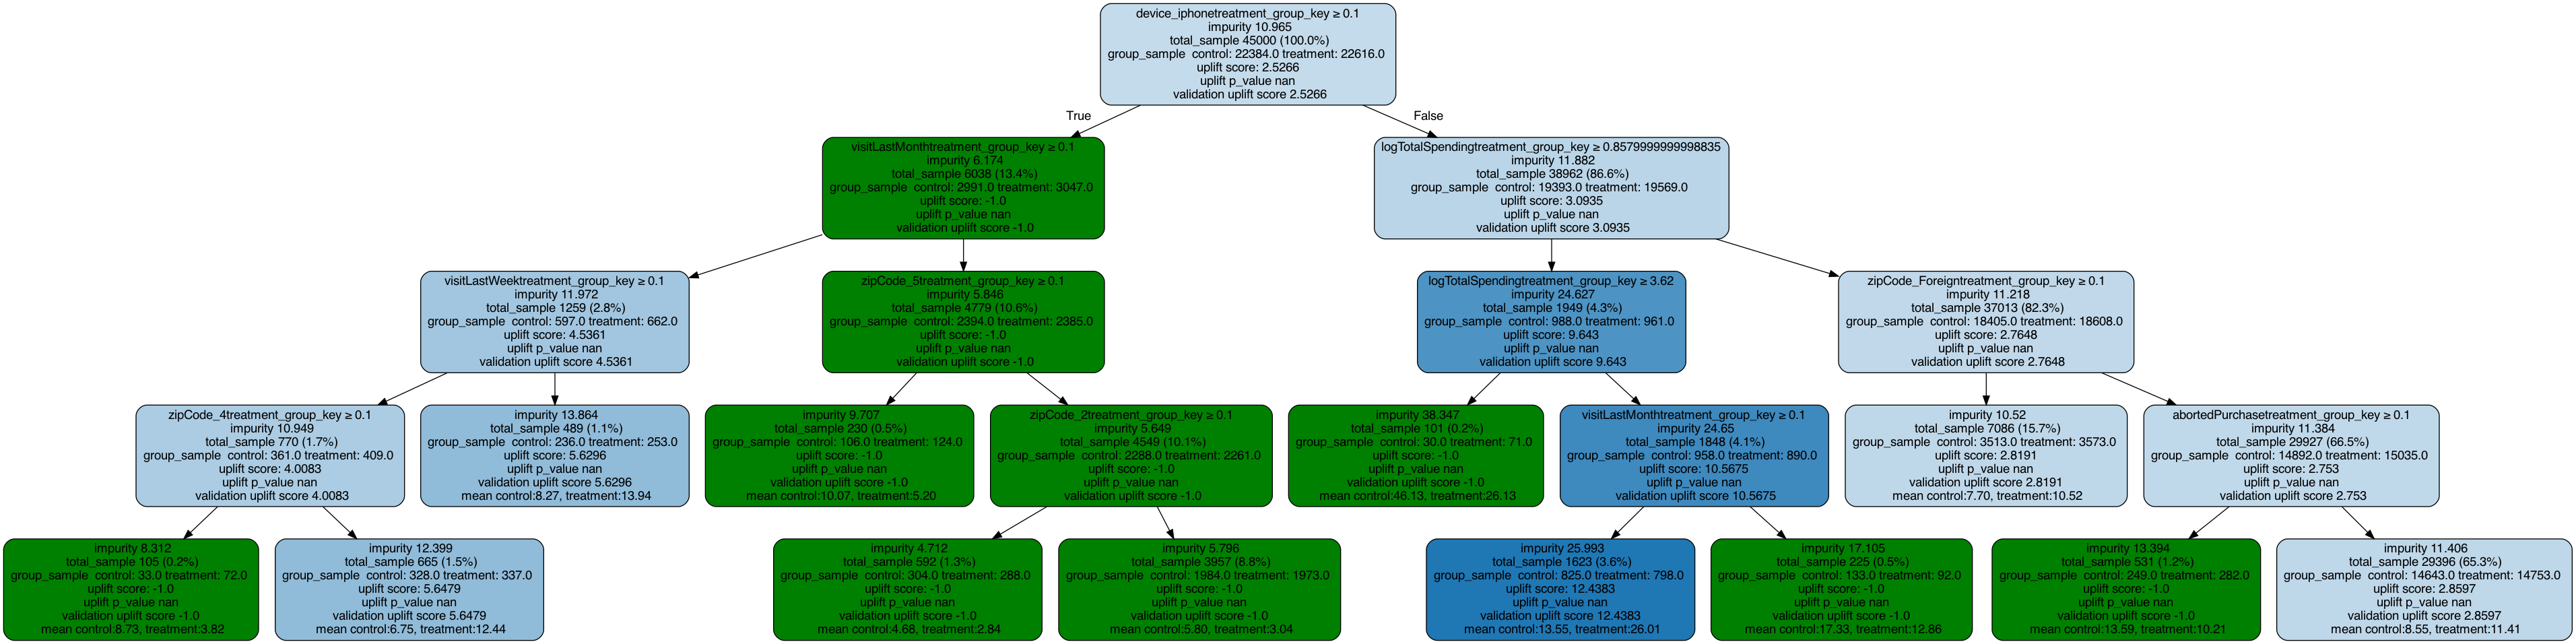

In [33]:
from IPython.display import Image
uplift_tree = uplift_RF.uplift_forest[0]
# Plot uplift tree (single tree)
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,X)
Image(graph.create_png())

In [34]:
#### Performance Assessment for Uplift Models ####
# Analyze the predicted values
np.mean(pred)
# The causal forest is not in line with the other models and the ATE



twomodel     0.225259
reg_TO       2.455296
Causal_RF    2.472492
dtype: float64

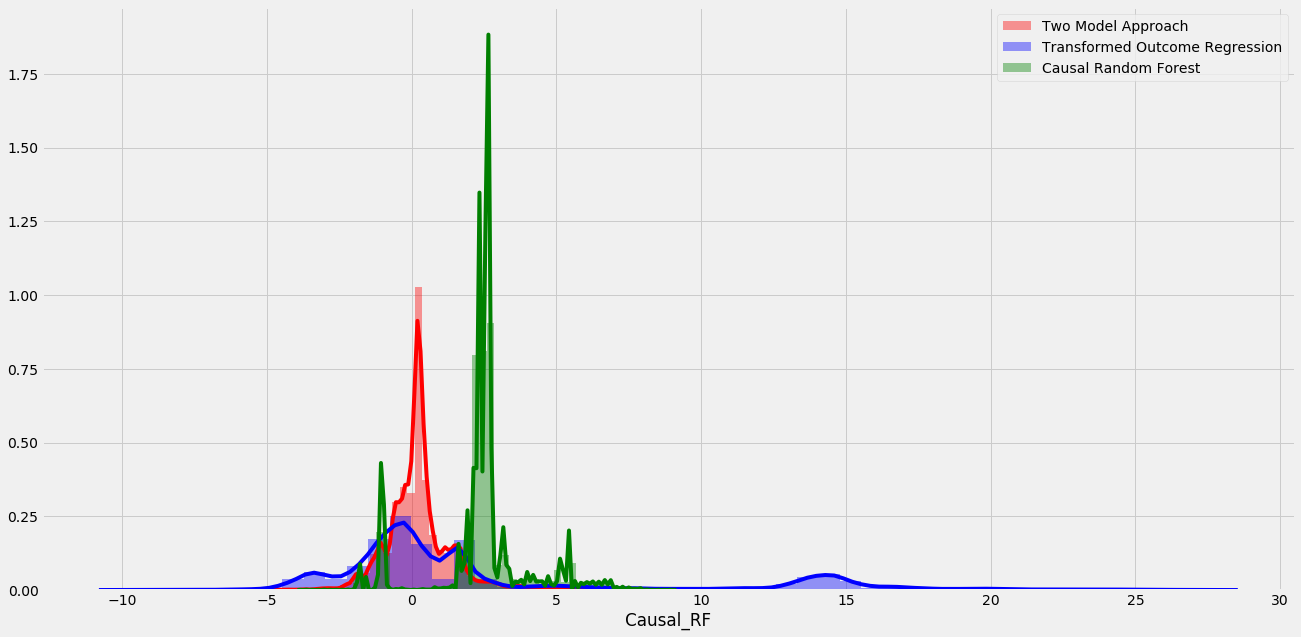

In [35]:
# Let's check what the models estimate on the individual level

import seaborn as sns
sns.distplot(pred['twomodel'], label="Two Model Approach", color='red')
sns.distplot(pred['reg_TO'], label= 'Transformed Outcome Regression', color='blue')
sns.distplot(pred['Causal_RF'], label = 'Causal Random Forest',  color='green')
plt.legend() ;

In [36]:
# There seem to be many cases where the treatment decreases conversion!

In [37]:
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklift.metrics import qini_auc_score, uplift_auc_score, uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves


In [38]:
#### Transformed Outcome Loss
# the lower the better

for model in pred.columns:
    print(model)
    print(np.mean((test_spending_TO - pred[model]).pow(2)))
    print('')
    



twomodel
2549.9828502752466

reg_TO
2514.37789747339

Causal_RF
2545.5290861046306



In [39]:
#### Qini score

# Calculate the Qini for each model
# The higher the better!

for model in pred.columns:
        temp = qini_auc_score(y_true=test[y], uplift=pred[model], treatment=test[T])
        print(model)
        print(temp)
        print(" ")
        


twomodel
226161662.05969197
 
reg_TO
226360509.5078008
 
Causal_RF
220335351.26099667
 


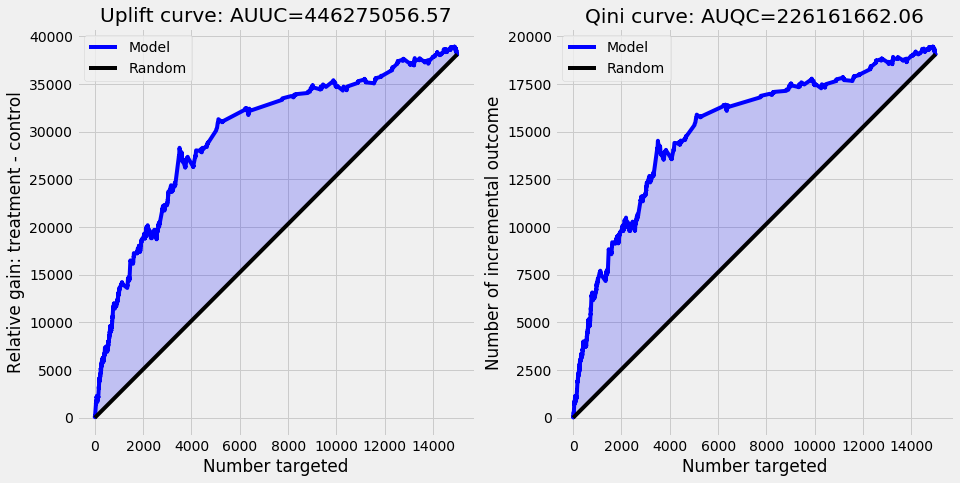

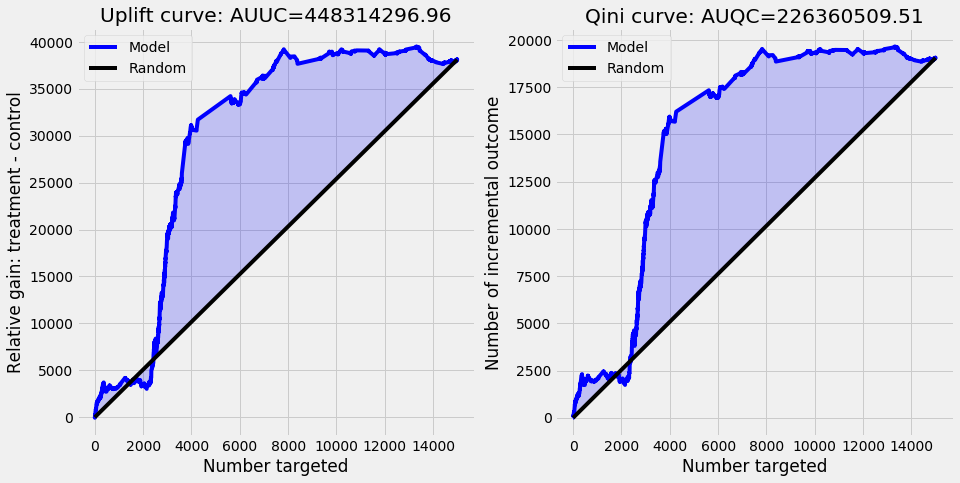

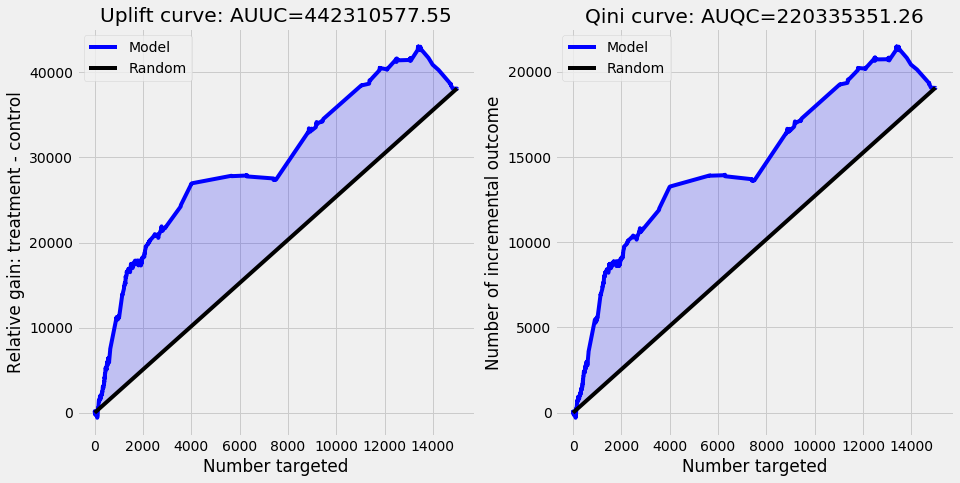

In [40]:
#### Qini and Uplift Curve 

for model in pred.columns:
    #todo add legend/title
    plot_uplift_qini_curves(y_true=test[y], uplift=pred[model], treatment=test[T]);

In [41]:
#### Bonus: Qini explanation ####
# Equivalent to the standard model lift, we can calculate the uplift for the sample deciles based on the model score

# Sort the observation by their estimates
# People with a higher effect are treated earlier

In [42]:
qini_data = pd.concat([test[['spending10days', 'conversion10days', 'treatment']], pred['Causal_RF']], axis=1,  names=['spending10days', 'conversion10days', 'treatment', 'effect_estimate'])
qini_data = qini_data.rename(columns={'Causal_RF': 'effect_estimate'})
qini_data = qini_data.sort_values(by='effect_estimate', ascending=False)
qini_data

,spending10days,conversion10days,treatment,effect_estimate
17014,64.093178,1,1,9.008695
31130,48.118518,1,0,8.979377
31153,53.912589,1,0,8.640432
38295,27.058457,1,0,8.559001
29373,63.797775,1,1,8.234308
...,...,...,...,...
28768,0.000000,0,1,-3.040772
56060,0.000000,0,0,-3.081502
25060,0.000000,0,1,-3.594085
30139,0.000000,0,0,-3.813675


In [43]:
# We cannot calculate the true treatment effect per person, but per group
# Bin the observations into ten groups based on their estimated effect

# mean effect estimate per decile
labels = list(range(1,11))
score_deciles = qini_data.groupby(pd.qcut(qini_data['effect_estimate'], 10, labels=labels))['effect_estimate'].mean()
score_deciles 

# create variable with label for each decile
qini_data['decile'] = pd.qcut(qini_data['effect_estimate'], 10, labels=labels)
qini_data

,spending10days,conversion10days,treatment,effect_estimate,decile
17014,64.093178,1,1,9.008695,10
31130,48.118518,1,0,8.979377,10
31153,53.912589,1,0,8.640432,10
38295,27.058457,1,0,8.559001,10
29373,63.797775,1,1,8.234308,10
...,...,...,...,...,...
28768,0.000000,0,1,-3.040772,1
56060,0.000000,0,0,-3.081502,1
25060,0.000000,0,1,-3.594085,1
30139,0.000000,0,0,-3.813675,1


In [44]:
n_treated_groups = qini_data[['decile', 'treatment']].groupby('decile').sum()
n_treated_groups

,treatment
decile,
1,765
2,841
3,1164
4,252
5,748
6,899
7,850
8,530
9,704


In [45]:
# We will later need the list in the opposite order, so we reverse the array
n_treated_groups = n_treated_groups[::-1]

In [46]:
## Qini for binary target outcomes

3278732.022682283


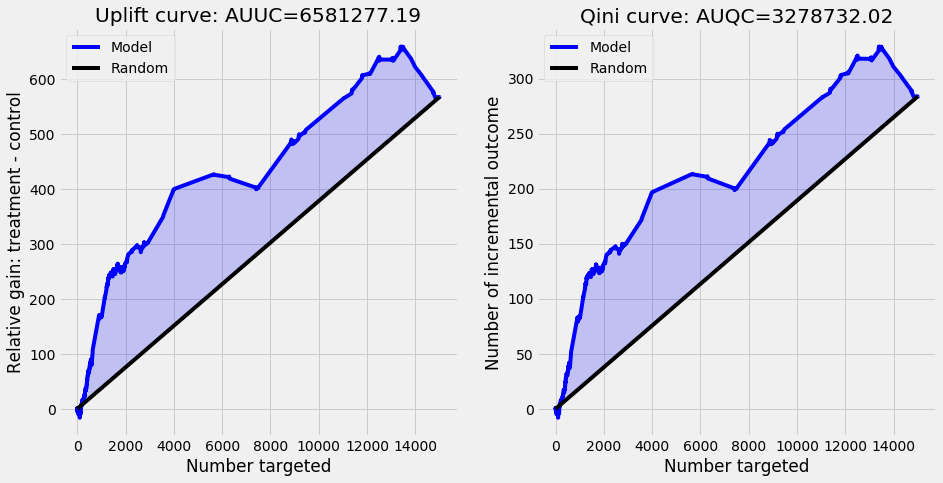

In [47]:
print(qini_auc_score(y_true=test['conversion10days'], uplift=pred["Causal_RF"], treatment=test[T])) #redundant 
plot_uplift_qini_curves(y_true=test['conversion10days'], uplift=pred["Causal_RF"], treatment=test[T]);

In [48]:
# Calculate the treatment effect within the treatment and control group of each decile (20 groups)

In [49]:
treatment_estimate_groups = qini_data[['decile', 'treatment', 'conversion10days', 'effect_estimate']].groupby(['decile','treatment']).mean() 
treatment_estimate_groups

conversion10days  effect_estimate
decile treatment                                   
1      0                  0.107483        -1.163853
       1                  0.052288        -1.144741
2      0                  0.180425         1.846875
       1                  0.209275         1.873130
3      0                  0.064298         2.307933
       1                  0.105670         2.308707
4      0                  0.134199         2.367974
       1                  0.186508         2.373219
5      0                  0.161905         2.506532
       1                  0.216578         2.506210
6      0                  0.189968         2.598155
       1                  0.176863         2.598227
7      0                  0.139771         2.646553
       1                  0.160000         2.646531
8      0                  0.109375         2.716227
       1                  0.194340         2.715591
9      0                  0.162011         3.387572
       1                  0.196023         3.376614
10     0                  0.193891         5.686550
       1                  0.362784         5.634131

In [50]:
# As before, we can calculate the average treatment effect in each group
ATE_groups = []
treatment_conversion = treatment_estimate_groups['conversion10days'][1::2].values
control_conversion = treatment_estimate_groups['conversion10days'][0::2].values

for treatment, control in zip(treatment_conversion, control_conversion):
    temp = round(treatment-control, 4)
    ATE_groups.append(temp)
    
ATE_groups


[-0.0552,
 0.0289,
 0.0414,
 0.0523,
 0.0547,
 -0.0131,
 0.0202,
 0.085,
 0.034,
 0.1689]

In [51]:
ATE_groups = ATE_groups[::-1] #todo maybe reverse neither?

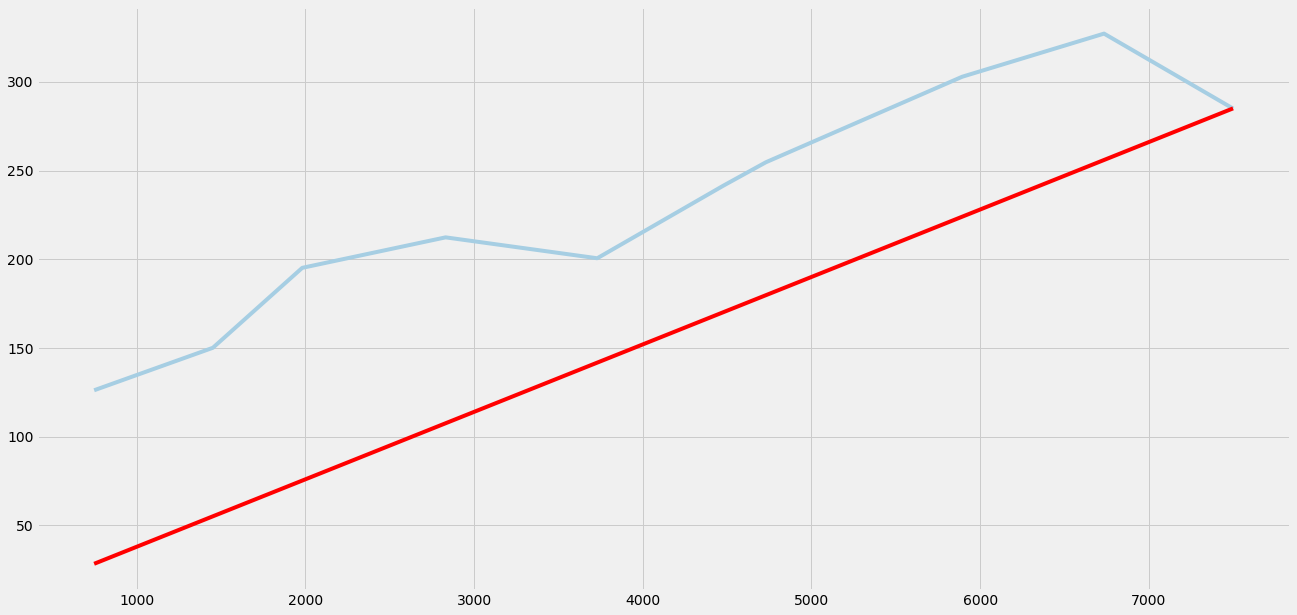

In [52]:
# The incremental gain is the cumulative effect of treating more customers
plt.plot((np.cumsum(n_treated_groups)), (np.cumsum(np.array(n_treated_groups['treatment'])*(ATE_groups))))

# Under random targeting, the treatment effect for each group is the same as the overall treatment effect

ATE_conversion = np.mean(treatment_group['conversion10days']) - np.mean(control_group['conversion10days'])
plt.plot(np.cumsum(n_treated_groups), np.cumsum(ATE_conversion*n_treated_groups['treatment'])
, color='red');

In [53]:
# The Qini coefficient is the ratio between two areas: 
# 1) The area under the model curve and above the random diagonal
# 2) The area under the optimal curve and above the random diagonal
# Since the area under the optimal curve is constant for all models, the area under the model curve is sufficient
# for model comparison


## Continuous target variable
#qini_score(scores = pred[["causal_forest"]], Y = testData$conversion10days, W = testData$treatment, p_treatment = 0.5, groups = 10, plotit = TRUE)

# Calculate the treatment effect within the treatment and control group of each decile (20 groups)
# This time on the target variable "spending"

treatment_estimate_groups= treatment_estimate_groups = qini_data[['decile', 'treatment', 'spending10days', 'effect_estimate']].groupby(['decile','treatment']).mean()
treatment_estimate_groups

spending10days  effect_estimate
decile treatment                                 
1      0                6.267555        -1.163853
       1                3.404329        -1.144741
2      0               10.633257         1.846875
       1               11.950380         1.873130
3      0                3.748074         2.307933
       1                6.226542         2.308707
4      0                7.939742         2.367974
       1               10.898228         2.373219
5      0                9.320007         2.506532
       1               13.198429         2.506210
6      0               10.943860         2.598155
       1               10.720448         2.598227
7      0                8.389682         2.646553
       1                9.192746         2.646531
8      0                6.361563         2.716227
       1               10.805956         2.715591
9      0                9.550925         3.387572
       1               12.585934         3.376614
10     0               11.079613         5.686550
       1               22.670199         5.634131

In [54]:
# As before, we can calculate the average treatment effect in each group
ATE_groups = []
treatment_conversion = treatment_estimate_groups['spending10days'][1::2].values
control_conversion = treatment_estimate_groups['spending10days'][0::2].values

for treatment, control in zip(treatment_conversion, control_conversion):
    temp = round(treatment-control, 4)
    ATE_groups.append(temp)
    
ATE_groups
ATE_groups = ATE_groups[::-1] 

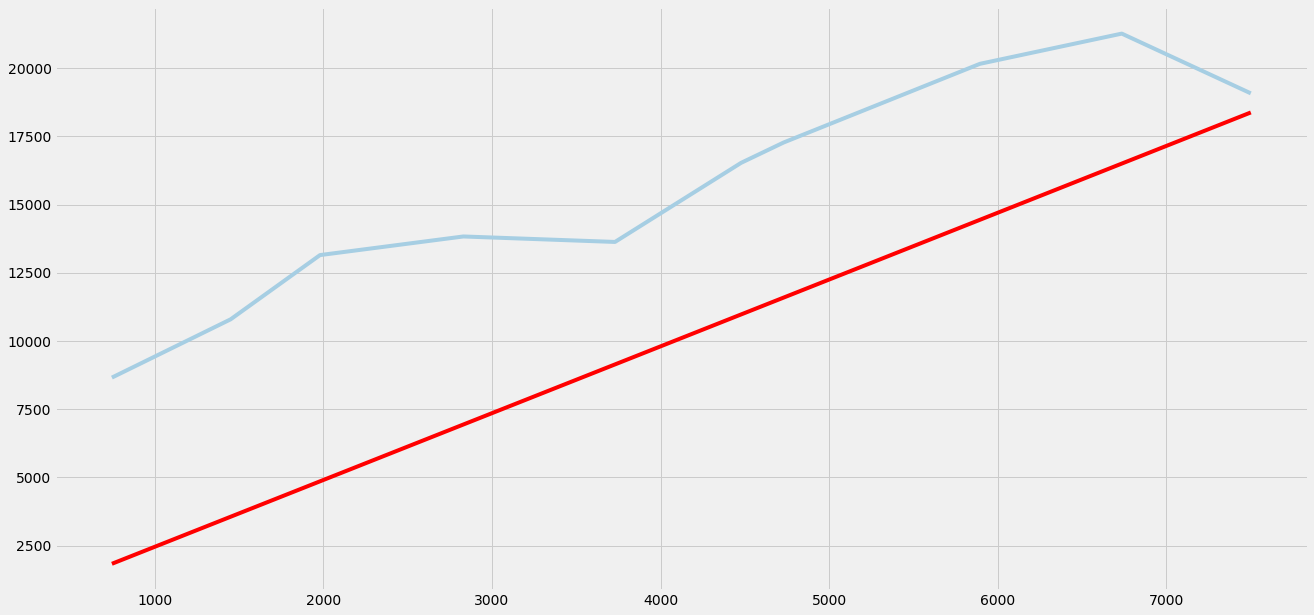

In [55]:
# The incremental gain is the cumulative effect of treating more customers
plt.plot((np.cumsum(n_treated_groups)), (np.cumsum(np.array(n_treated_groups['treatment'])*(ATE_groups))))

# Under random targeting, the treatment effect for each group is the same as the overall treatment effect

ATE_conversion = np.mean(treatment_group['spending10days']) - np.mean(control_group['spending10days'])
plt.plot(np.cumsum(n_treated_groups), np.cumsum(ATE_conversion*n_treated_groups['treatment'])
, color='red');

# The Qini coefficient is the ratio between two areas: 
# 1) The area under the model curve and above the random diagonal
# 2) The area under the optimal curve and above the random diagonal: The optimal curve is hard to define for 
#     continuous outcomes, so the area under the model curve is typically used for model comparison

